##### imports

In [1425]:
from numpy import exp
from numpy import sqrt
from numpy import cos
from numpy import e
from numpy import pi
from typing import List, Callable, Tuple
import random

#### Definindo váriaveis e função de avaliação

In [1426]:
A = 20
B = 0.2
C = 2 * pi
D = 30

In [1427]:
TAM_DA_POPULACAO = 30
QTD_DE_FILHOS = 7 * TAM_DA_POPULACAO
POPULACAO = []
PROB_MUTACAO = 0.2
TAXA_APRENDIZAGEM = 1 / sqrt(D)
EPSILON_0 = 0.001
EPSILON_1 = 10
MAX_ITERS = 10_000
CURR_SUCCESS = 0
FITNESS_FUNC = None
CROSSOVER_FUNC = None
SURV_SELECTION_FUNC = None

In [1428]:
def ackley_funct(x: List[float]):
  return - A * exp(-B * sqrt(sum(map(lambda n: n ** 2, x)) / D)) \
          - exp(sum(map(lambda n: cos(C * n), x)) / D) \
          + A + exp(1)

In [1429]:
def sum_squares_function(x: List[float]):
    soma = 0

    for i in range(D):
        soma += (i+1) * x[i] ** 2

    return soma

In [1430]:
FITNESS_FUNC = sum_squares_function

In [1431]:
def fitness(fitness_func: Callable, cromossome: List[float]):
    return fitness_func(cromossome)

In [1432]:
print(f'{ackley_funct([0 for _ in range(30)]) : .15f}')

 0.000000000000000


# Estratégia Evolutiva

## Inicialização da população

In [1433]:
def generate_individual():
  x = []
  for i in range(D):
    x.append(random.uniform(-15, 15))
    
  return x

In [1434]:
def generate_population():
  global POPULACAO, TAM_DA_POPULACAO
  
  for _ in range(TAM_DA_POPULACAO):
    POPULACAO.append((generate_individual(), random.normalvariate(0, 1)))

In [1435]:
def reset_population() -> None:
    global POPULACAO

    POPULACAO = []

## Seleção de pais

In [1436]:
def select_parents():
    global POPULACAO

    pai1, pai2 = random.sample(POPULACAO, 2)

    return pai1, pai2

## Recombinação

In [1437]:
# Local discreto
def evolutive_crossover(pai1: Tuple[List[float], float], pai2: Tuple[List[float], float]):
    global CROSSOVER_FUNC
    return CROSSOVER_FUNC(pai1, pai2)

In [1438]:
def local_intermediary(pai1: Tuple[List[float], float], pai2: Tuple[List[float], float]):
    filho = []
    for i in range(D):
        filho += [(pai1[0][i] + pai2[0][i])/2]
        
    sigma = (pai1[1] + pai2[1])/2

    return filho, sigma

In [1439]:
def local_discrete(pai1: Tuple[List[float], float], pai2: Tuple[List[float], float]):
    filho = []
    for i in range(D):
        filho += random.sample([pai1[0][i], pai2[0][i]], 1)
        
    sigma = random.sample([pai1[1], pai2[1]], 1)[0]

    return filho, sigma

In [1440]:
CROSSOVER_FUNC = local_intermediary

In [1441]:
def crossover():
    global QTD_DE_FILHOS

    filhos = []
    for _ in range(QTD_DE_FILHOS):
        pai1, pai2 = select_parents()
        filhos.append(evolutive_crossover(pai1, pai2))

    return filhos

## Mutação

In [1442]:
def regra_1_quinto(sigma: float, sucesso: float) -> float:
    c = 0.8
    
    if sucesso > 1 / 5:
        sigma = sigma / c
    elif sucesso < 1 / 5:
        sigma = sigma * c
    
    return sigma

In [1443]:
def calc_sigma(sigma: float) -> float:
    global TAXA_APRENDIZAGEM, EPSILON_0, EPSILON_1

    new_sigma = sigma * exp(TAXA_APRENDIZAGEM * random.normalvariate(0, 1))

    return min(max(new_sigma, EPSILON_0), EPSILON_1)

In [1444]:
def test_success(old_indiv_fitness, new_indiv_fitness):
    global CURR_SUCCESS

    if new_indiv_fitness < old_indiv_fitness:
        CURR_SUCCESS += 1

In [1445]:
def get_success() -> float:
    global CURR_SUCCESS
    
    return CURR_SUCCESS / QTD_DE_FILHOS

In [1446]:
def reset_success() -> None:
    global CURR_SUCCESS

    CURR_SUCCESS = 0

In [1447]:
def mutate_and_calc_sucess(individuo: List[float], sigma: float):
    global FITNESS_FUNC
    
    novo_sigma = calc_sigma(sigma)

    old_fitness = fitness(FITNESS_FUNC, individuo)
    
    for i in range(len(individuo)):
        individuo[i] = min(max(individuo[i] + novo_sigma * random.normalvariate(0, 1), -15), 15)

    new_fitness = fitness(FITNESS_FUNC, individuo)
    test_success(old_fitness, new_fitness)

    return individuo, novo_sigma

In [1448]:
def mutate(filhos: List[Tuple[List[float], float]]):
    global QTD_DE_FILHOS

    filhos_mutados = []
    for i in range(QTD_DE_FILHOS):
            filhos_mutados.append(mutate_and_calc_sucess(filhos[i][0], filhos[i][1]))

    return filhos_mutados

## Seleção de sobreviventes

#### Geracional

In [1449]:
def generational(filhos: List[Tuple[List[float], float]], iteration):
    global POPULACAO, FITNESS_FUNC, TAM_DA_POPULACAO
    reset_population()
    
    filhos.sort(key=lambda filho: fitness(FITNESS_FUNC, filho[0]), reverse=False)
    POPULACAO = filhos[:TAM_DA_POPULACAO]

In [1450]:
def elitist(filhos: List[Tuple[List[float], float]], iteration):
    global POPULACAO, FITNESS_FUNC, TAM_DA_POPULACAO
    
    POPULACAO += filhos
    POPULACAO.sort(key=lambda filho: fitness(FITNESS_FUNC, filho[0]), reverse=False)
    POPULACAO = POPULACAO[:TAM_DA_POPULACAO]

In [1451]:
SURV_SELECTION_FUNC = generational

## Condição de parada

In [1452]:
def is_close(a: float, b: float, diff: float = 0.00001):
    if a + diff > b and b + diff > a:
        return True
        
    return False

In [1453]:
def should_stop(curr_best_fitness: float, curr_iter: int):
    if is_close(curr_best_fitness, 0):
        return True
    if curr_iter == MAX_ITERS:
        return True
    
    return False

## Evolução

In [1454]:
def generate_solution():
    global POPULACAO, TAM_DA_POPULACAO
    iteration = 0

    best_fitness = float("inf")
    best_solution = None
    bests_fitness = []
    bests_sigma = []

    while (not should_stop(best_fitness, iteration)):
        reset_success()

        filhos = crossover()    
        filhos = mutate(filhos)

        success = get_success()

        for i in range(len(filhos)):
            filhos[i] = (filhos[i][0], regra_1_quinto(filhos[i][1], success))


        SURV_SELECTION_FUNC(filhos, iteration)
        

        curr_best_fitness = fitness(FITNESS_FUNC, POPULACAO[0][0])
        bests_fitness.append(curr_best_fitness)
        bests_sigma.append(POPULACAO[0][1])

        if curr_best_fitness <= best_fitness:
            best_fitness = curr_best_fitness
            best_solution = POPULACAO[0][0]

        #if iteration % 1000 == 0:
            #print(best_fitness, POPULACAO[0][1], POPULACAO[0][0])
            #print("iteration:", iteration, best_fitness, POPULACAO[0][1])

        iteration += 1
        if iteration % 200 == 0:
            # Aumentar a mutação ao inves de resetar tudo?
            reset_population()
            generate_population()

    # print(best_fitness, best_solution, iteration)
    return best_fitness, best_solution, bests_fitness, bests_sigma, iteration


## Resultados

In [1455]:
import matplotlib.pyplot as plt
import numpy as np

In [1464]:
def plot_results(best_fitness, best_solution, bests_fitness, bests_sigma, iteration) -> None:
    fig = plt.figure(figsize=(12, 6))
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    fig.suptitle('Evolution x iteration')
    
    # Fitness
    ax1.plot(range(0,iteration), bests_fitness)
    ax1.set(xlabel='iteration', ylabel='melhor fitness',
           title='fitness evolution')
    ax1.grid()

    # Desvio Padrão
    ax2.plot(range(0,iteration), bests_sigma)
    ax2.set(xlabel='iteration', ylabel='melhor desvio padrão',
           title='sigma evolution')
    ax2.grid()

    fig.tight_layout()
    plt.show()

    print(best_fitness, best_solution)

In [1457]:
global POPULACAO

reset_population()
generate_population()
POP_TEST = POPULACAO.copy()

In [1458]:
FITNESS_FUNC = ackley_funct
CROSSOVER_FUNC = local_discrete
SURV_SELECTION_FUNC = generational
POPULACAO = POP_TEST.copy()

best_fitness, best_solution, bests_fitness, bests_sigma, iteration = generate_solution()

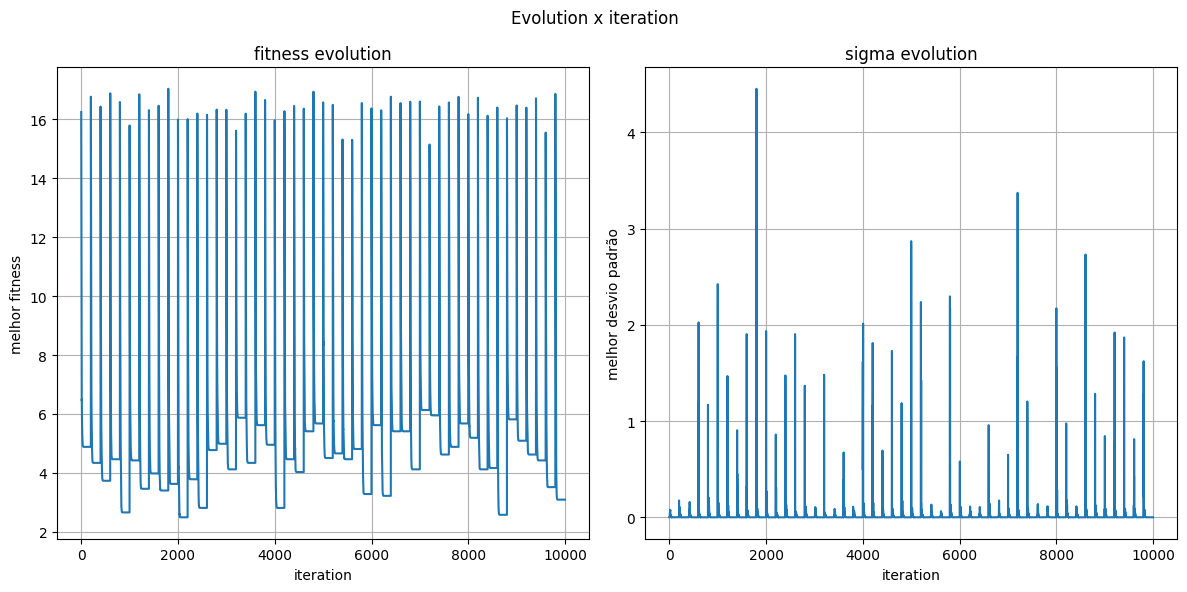

2.495456347859229 [0.0002675213722242067, 0.0006396148357705165, -0.0007526944542013881, -0.952159478904621, -0.948583685705358, -0.000739619905772372, 0.0005507666665979657, -0.9486288404193254, -0.9495476805808446, 0.9519834634226857, 0.9488205215731322, -0.9504244939325195, 0.0005559133704245919, -1.8941553194712313, -0.0012359664212909511, -0.00030948681699311605, -0.000817634850758429, 0.0006314500315834338, 0.9477541111790733, -0.000597794077869753, -0.9502190020142305, -0.00020694079156951444, 0.951452354619978, -0.0008117900180116559, -0.0011249206947225397, -8.485134127707902e-05, 0.0013505521052434876, -0.00032486364299831995, -0.0002990431423551667, 0.00029272238319275897]


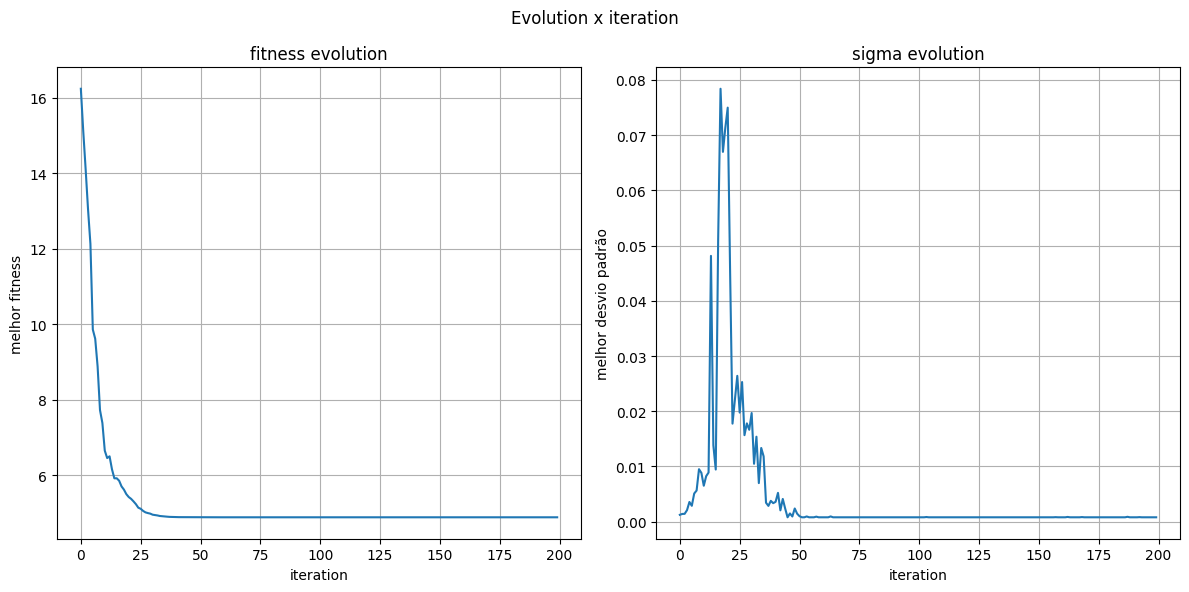

2.495456347859229 [0.0002675213722242067, 0.0006396148357705165, -0.0007526944542013881, -0.952159478904621, -0.948583685705358, -0.000739619905772372, 0.0005507666665979657, -0.9486288404193254, -0.9495476805808446, 0.9519834634226857, 0.9488205215731322, -0.9504244939325195, 0.0005559133704245919, -1.8941553194712313, -0.0012359664212909511, -0.00030948681699311605, -0.000817634850758429, 0.0006314500315834338, 0.9477541111790733, -0.000597794077869753, -0.9502190020142305, -0.00020694079156951444, 0.951452354619978, -0.0008117900180116559, -0.0011249206947225397, -8.485134127707902e-05, 0.0013505521052434876, -0.00032486364299831995, -0.0002990431423551667, 0.00029272238319275897]


In [1467]:
plot_results(best_fitness, best_solution, bests_fitness, bests_sigma, iteration)
plot_results(best_fitness, best_solution, bests_fitness[:200], bests_sigma[:200], min(iteration,200))

In [1468]:
FITNESS_FUNC = ackley_funct
CROSSOVER_FUNC = local_discrete
SURV_SELECTION_FUNC = elitist
POPULACAO = POP_TEST.copy()

best_fitness, best_solution, bests_fitness, bests_sigma, iteration = generate_solution()

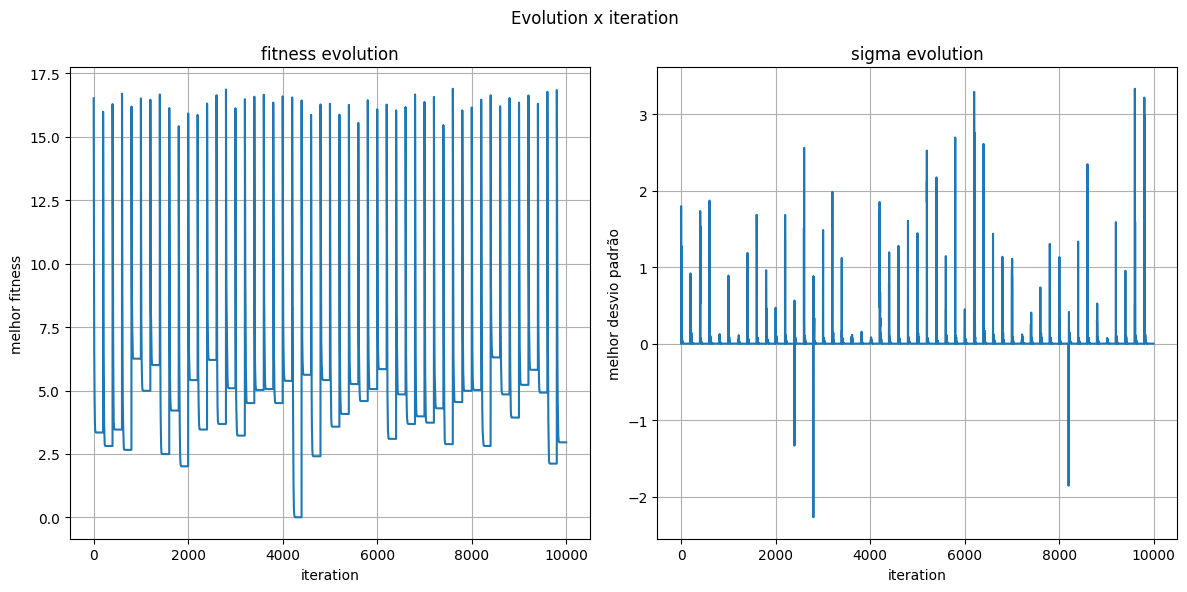

0.002774278316426848 [-0.0009135470829053167, 7.158536145731025e-05, -0.00022566814251804017, -0.0007856990625078967, -0.00107625973100007, 6.193222148200505e-05, 1.651001942800886e-05, 6.408094224294772e-05, -0.0004962733422284733, 0.00047852872687499377, -0.0016051700522162053, 0.0003082843881813788, -6.802480894611913e-05, 0.0010008993849944766, -0.0013386084829371588, -3.392340415546511e-05, -0.0010518612604148432, 0.0006787292443102002, 3.5601384285495366e-05, -5.463219221934671e-05, -1.7912243532612046e-05, -0.0006944763580014589, -0.0007050292637935032, 0.0005717071857793518, 0.0007632860152932009, 0.0005977231125464677, -0.0003762975174789531, 0.0009281965400161224, 0.00014479888725630667, -0.0008413948402951077]


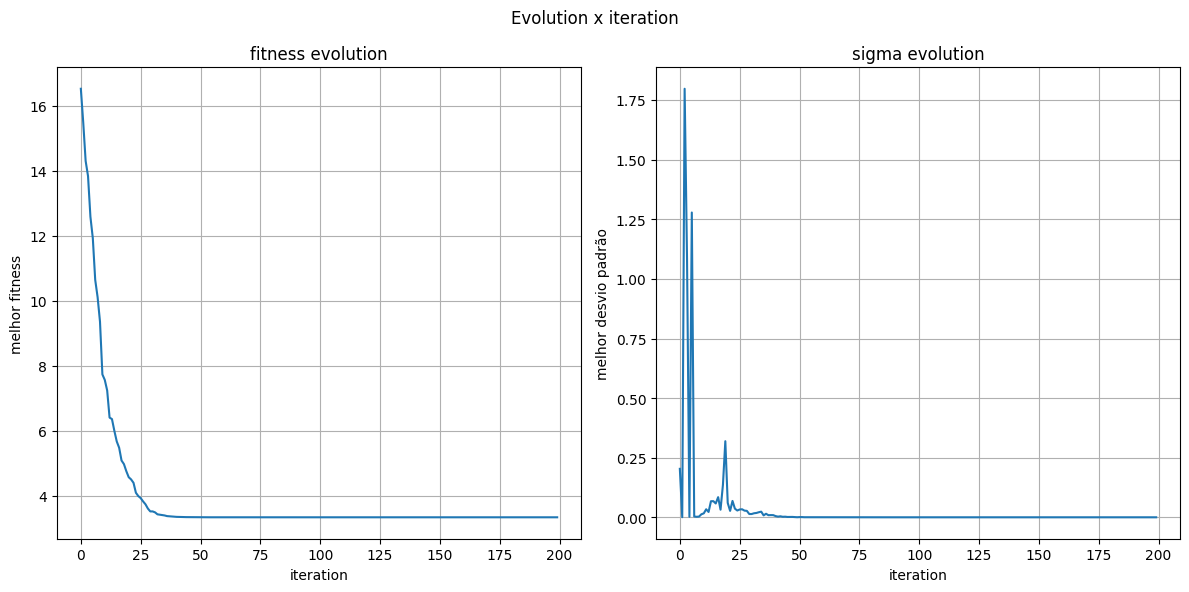

0.002774278316426848 [-0.0009135470829053167, 7.158536145731025e-05, -0.00022566814251804017, -0.0007856990625078967, -0.00107625973100007, 6.193222148200505e-05, 1.651001942800886e-05, 6.408094224294772e-05, -0.0004962733422284733, 0.00047852872687499377, -0.0016051700522162053, 0.0003082843881813788, -6.802480894611913e-05, 0.0010008993849944766, -0.0013386084829371588, -3.392340415546511e-05, -0.0010518612604148432, 0.0006787292443102002, 3.5601384285495366e-05, -5.463219221934671e-05, -1.7912243532612046e-05, -0.0006944763580014589, -0.0007050292637935032, 0.0005717071857793518, 0.0007632860152932009, 0.0005977231125464677, -0.0003762975174789531, 0.0009281965400161224, 0.00014479888725630667, -0.0008413948402951077]


In [1469]:
plot_results(best_fitness, best_solution, bests_fitness, bests_sigma, iteration)
plot_results(best_fitness, best_solution, bests_fitness[:200], bests_sigma[:200], min(iteration,200))

In [1470]:
FITNESS_FUNC = ackley_funct
CROSSOVER_FUNC = local_intermediary
SURV_SELECTION_FUNC = generational
POPULACAO = POP_TEST.copy()

best_fitness, best_solution, bests_fitness, bests_sigma, iteration = generate_solution()

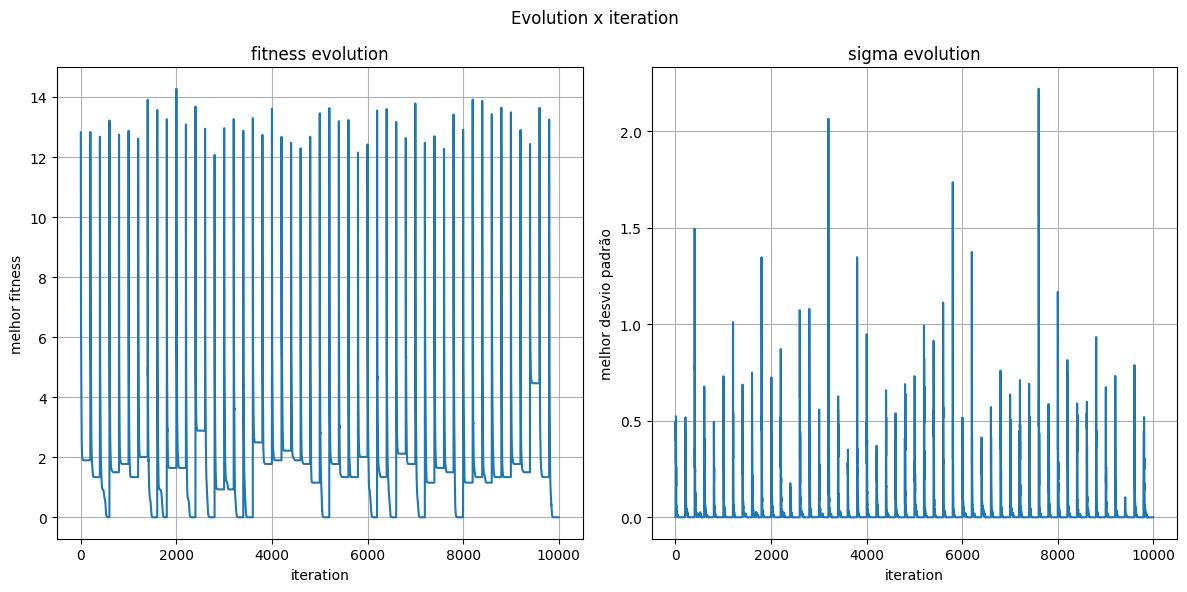

0.0024032164715035442 [0.0006564032446181644, -0.00035966108587218615, -0.00039496855802951094, 0.0016335933467736816, -3.257703249329084e-05, 0.0005170962985726377, 0.0009116457893185843, -0.0004264161434712011, -0.0005247542367468891, -0.001301723141752878, -0.0005153167566146368, 0.00024736305519791184, 0.00022688565153788877, 7.269052473949061e-05, 0.0006683968323098229, -0.0002833404212098207, 0.0001835243251969899, -0.0002185804519200719, -0.00019598819870084172, 0.0005352172122106262, 0.0003297482952371032, 0.0002773714472724425, -0.0005651408233138588, 0.0004073211791984149, -3.413721570906677e-05, 0.000692088540332571, 0.0007047608759683417, 0.0006870926332060217, 0.0004636730883035698, -0.0006093249579380712]


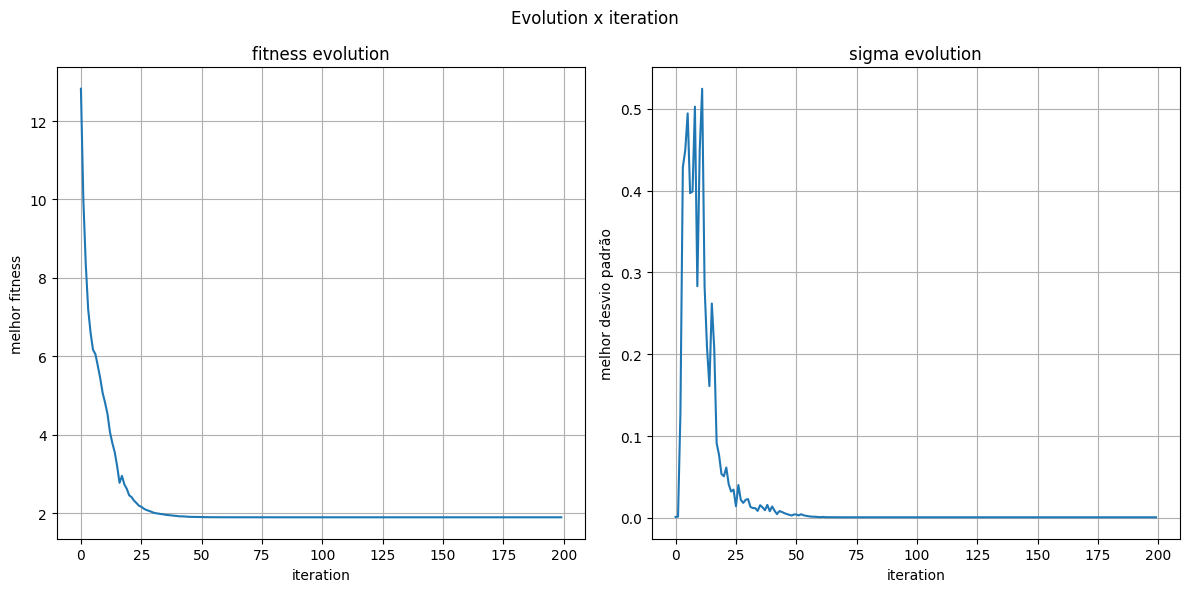

0.0024032164715035442 [0.0006564032446181644, -0.00035966108587218615, -0.00039496855802951094, 0.0016335933467736816, -3.257703249329084e-05, 0.0005170962985726377, 0.0009116457893185843, -0.0004264161434712011, -0.0005247542367468891, -0.001301723141752878, -0.0005153167566146368, 0.00024736305519791184, 0.00022688565153788877, 7.269052473949061e-05, 0.0006683968323098229, -0.0002833404212098207, 0.0001835243251969899, -0.0002185804519200719, -0.00019598819870084172, 0.0005352172122106262, 0.0003297482952371032, 0.0002773714472724425, -0.0005651408233138588, 0.0004073211791984149, -3.413721570906677e-05, 0.000692088540332571, 0.0007047608759683417, 0.0006870926332060217, 0.0004636730883035698, -0.0006093249579380712]


In [1471]:
plot_results(best_fitness, best_solution, bests_fitness, bests_sigma, iteration)
plot_results(best_fitness, best_solution, bests_fitness[:200], bests_sigma[:200], min(iteration,200))

In [1472]:
FITNESS_FUNC = ackley_funct
CROSSOVER_FUNC = local_intermediary
SURV_SELECTION_FUNC = elitist
POPULACAO = POP_TEST.copy()

best_fitness, best_solution, bests_fitness, bests_sigma, iteration = generate_solution()

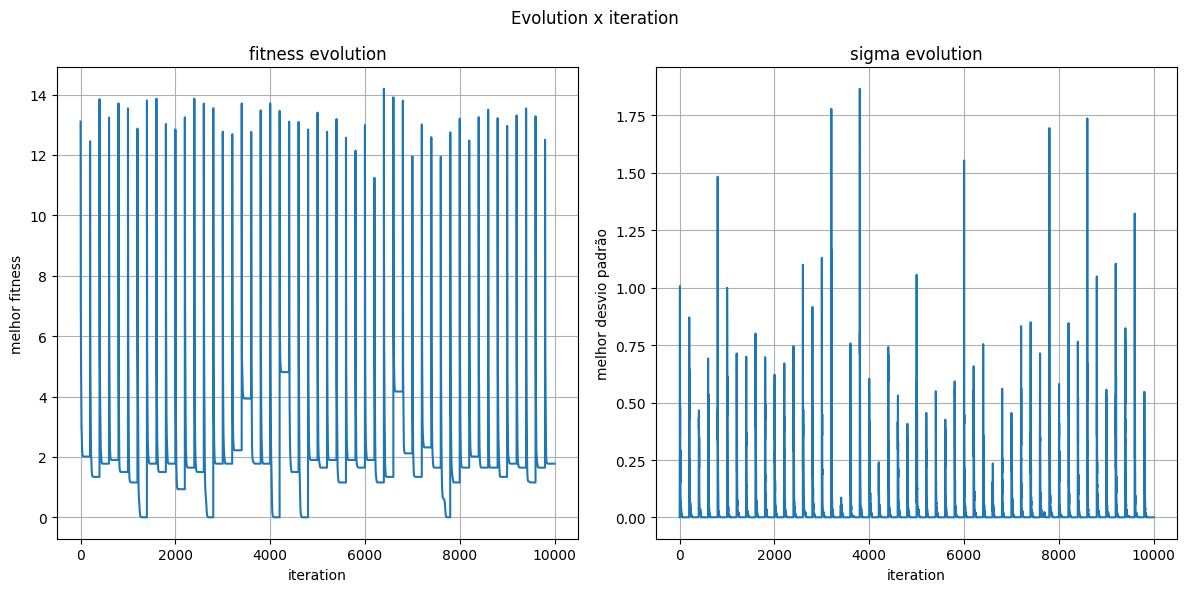

0.0021672026671279987 [9.10954505102616e-05, 0.0004481517301468753, 0.0002159511598141279, 0.00030645317950809804, -0.0003711057625684184, -0.0009833887162580084, 0.001160783124214445, -0.0002418657697976886, -0.0006281203787261917, -0.00032951387395436973, 0.00039133979950486004, 0.00038185747299889264, -0.00023415426836230436, 9.927629798923277e-05, 0.00081407885649678, 0.0007009847685510053, 3.0808591436995198e-06, -0.0005873471011035385, -0.0002936196378090921, -0.000993017097548273, -0.0002944042089160687, 7.311979561714125e-05, -7.100114234651024e-05, -0.0008111886916775776, -0.0008958729257127654, 0.00046262310911119014, -0.0004106346813796197, -0.0002747037588083681, 0.0005730307848007957, -0.0001973979891441501]


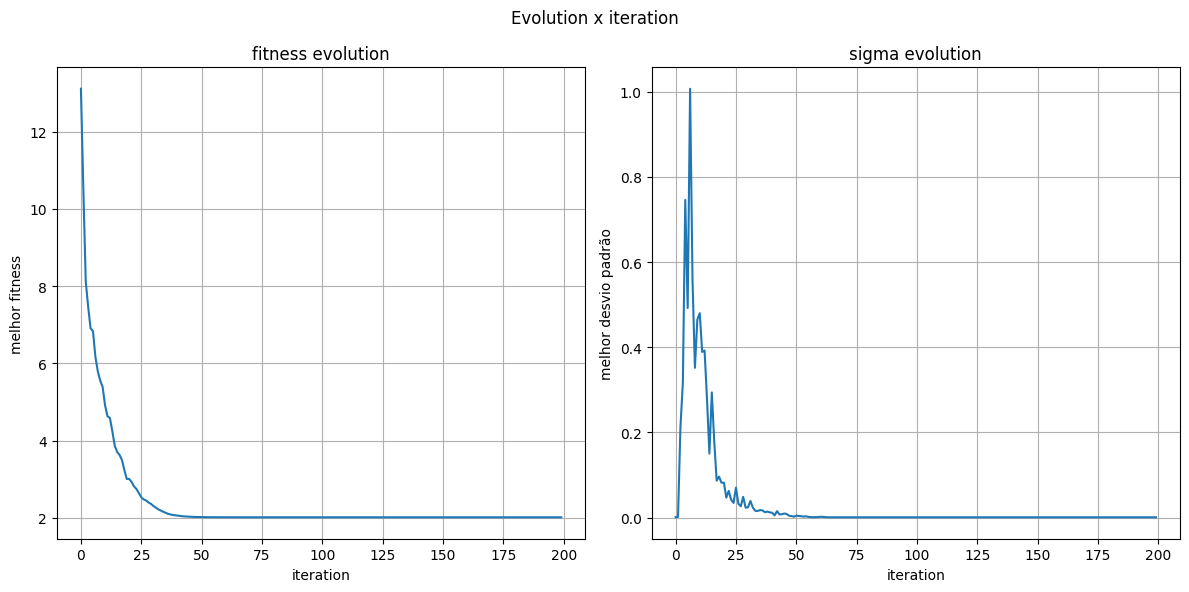

0.0021672026671279987 [9.10954505102616e-05, 0.0004481517301468753, 0.0002159511598141279, 0.00030645317950809804, -0.0003711057625684184, -0.0009833887162580084, 0.001160783124214445, -0.0002418657697976886, -0.0006281203787261917, -0.00032951387395436973, 0.00039133979950486004, 0.00038185747299889264, -0.00023415426836230436, 9.927629798923277e-05, 0.00081407885649678, 0.0007009847685510053, 3.0808591436995198e-06, -0.0005873471011035385, -0.0002936196378090921, -0.000993017097548273, -0.0002944042089160687, 7.311979561714125e-05, -7.100114234651024e-05, -0.0008111886916775776, -0.0008958729257127654, 0.00046262310911119014, -0.0004106346813796197, -0.0002747037588083681, 0.0005730307848007957, -0.0001973979891441501]


In [1473]:
plot_results(best_fitness, best_solution, bests_fitness, bests_sigma, iteration)
plot_results(best_fitness, best_solution, bests_fitness[:200], bests_sigma[:200], min(iteration,200))

# Estratégia Genética

## Versão 1